In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [3]:
# Import Lab
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import optimize, stats                    
import pandas_profiling as autoprofiling
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from keras.utils import np_utils
import tensorflow as tf

data source :[ find it here ](#https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

shortcut: kaggle competitions download -c competitive-data-science-predict-future-sales

In [4]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
df_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

In [5]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [8]:
df_test.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [9]:
#autoprofiling.ProfileReport(df_train)

### Data Description
#### File descriptions

    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    sample_submission.csv - a sample submission file in the correct format.
    items.csv - supplemental information about the items/products.
    item_categories.csv - supplemental information about the items categories.
    shops.csv- supplemental information about the shops.

####  Data fields

    ID - an Id that represents a (Shop, Item) tuple within the test set
    shop_id - unique identifier of a shop
    item_id - unique identifier of a product
    item_category_id - unique identifier of item category
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    item_price - current price of an item
    date - date in format dd/mm/yyyy
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    item_name - name of item
    shop_name - name of shop
    item_category_name - name of item category


<AxesSubplot:>

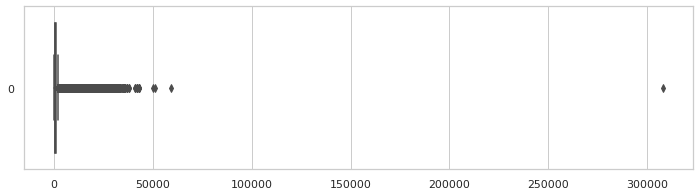

In [10]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 3))
sns.boxplot(data=df_train.item_price, orient='h')

In [11]:
# Remove large outliers
df_train = df_train[df_train.item_price < 100000]


<AxesSubplot:>

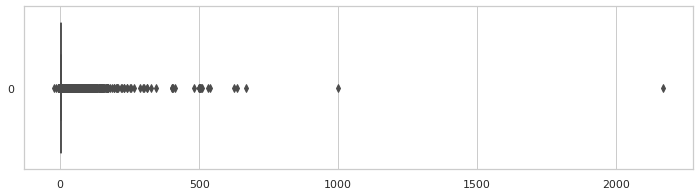

In [12]:
# let us zoom in
plt.figure(figsize=(12, 3))
sns.boxplot(data=df_train.item_cnt_day, orient='h')


In [13]:
#once again Remove large outliers
df_train = df_train[df_train.item_cnt_day < 900]

In [14]:
## monthly sales
df = df_train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day', fill_value=0, aggfunc='sum')
df = df.reset_index()
df.columns.name = None
df



,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424118,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424119,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
424120,59,22162,0,0,0,0,0,0,0,0,...,0,9,4,1,1,0,0,1,0,0
424121,59,22164,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,1,0,0,0


#### Merge past data to test one

In [15]:
df_test_src = pd.merge(df_test, df, how='left', on=['shop_id', 'item_id'])
df_test_src = df_test_src.drop(['ID'], axis=1).fillna(0)
df_test_src

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### feeding only explanatory and objective variables

In [16]:
X_train = df.iloc[:, 2:-1]
X_train

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424118,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424119,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,0,0,0,0,0,0,0,0,0,0,...,0,0,9,4,1,1,0,0,1,0
424121,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,2,0,0,1,0,0


In [17]:
y_train = df.iloc[:, -1]
y_train

0         0
1         0
2         0
3         0
4         0
         ..
424118    0
424119    0
424120    0
424121    0
424122    0
Name: 33, Length: 424123, dtype: int64

In [18]:
X_test = df_test_src.iloc[:, 3:]
X_test

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)
X_test  = X_scaler.transform(X_test)


In [20]:
input = tf.keras.layers.Input(shape=(33, 1))

x = input
x = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1)(x)
x = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1)(x)
x = tf.keras.layers.LSTM(32)(x)

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(input, output)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 33, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='mse')


### Training 

In [22]:
epochs = 100
batch_size = 64

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(np.expand_dims(X_train, axis=-1),
                    y_train,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)


Epoch 1/100
5302/5302 [==============================] - 53s 9ms/step - loss: 5.9824 - val_loss: 1.0049
Epoch 2/100
5302/5302 [==============================] - 46s 9ms/step - loss: 4.7809 - val_loss: 0.9288
Epoch 3/100
5302/5302 [==============================] - 46s 9ms/step - loss: 6.5817 - val_loss: 0.8766
Epoch 4/100
5302/5302 [==============================] - 45s 9ms/step - loss: 5.6248 - val_loss: 0.8492
Epoch 5/100
5302/5302 [==============================] - 45s 9ms/step - loss: 5.2151 - val_loss: 0.7779
Epoch 6/100
5302/5302 [==============================] - 46s 9ms/step - loss: 4.4409 - val_loss: 0.7481
Epoch 7/100
5302/5302 [==============================] - 47s 9ms/step - loss: 3.4752 - val_loss: 0.7168
Epoch 8/100
5302/5302 [==============================] - 46s 9ms/step - loss: 3.9267 - val_loss: 0.7119
Epoch 9/100
5302/5302 [==============================] - 46s 9ms/step - loss: 3.2626 - val_loss: 0.6924
Epoch 10/100
5302/5302 [==============================] - 46s 9m

### Prediction

In [23]:
y_pred = model.predict(np.expand_dims(X_test, -1))
y_pred

array([[0.2742076 ],
       [0.18637288],
       [0.28277695],
       ...,
       [0.1867156 ],
       [0.18637288],
       [0.18617654]], dtype=float32)

In [24]:
y_pred = y_pred.squeeze().clip(0, 20)
y_pred

array([0.2742076 , 0.18637288, 0.28277695, ..., 0.1867156 , 0.18637288,
       0.18617654], dtype=float32)

In [25]:
submission = pd.concat([df_test['ID'], pd.Series(y_pred.squeeze(), name='item_cnt_month')], axis=1)
submission

,ID,item_cnt_month
0,0,0.274208
1,1,0.186373
2,2,0.282777
3,3,0.198312
4,4,0.186373
...,...,...
214195,214195,0.192213
214196,214196,0.186373
214197,214197,0.186716
214198,214198,0.186373


In [26]:
submission.to_csv("submission_2.csv", index=False)